In [3]:
import os
import cv2
from tqdm import tqdm


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import cv2
import numpy as np
cat_img = []
dog_img = []
panda_img = []
basepath = '/content/drive/MyDrive/300 images'
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            img = img.flatten()
            images.append(img)
            labels.append(label)
    return images, labels

In [8]:
basepath = '/content/drive/MyDrive/300 images'
cat_img, cat_labels = load_images(os.path.join(basepath, 'cat'), 0)
dog_img, dog_labels = load_images(os.path.join(basepath, 'dog'), 1)
panda_img, panda_labels = load_images(os.path.join(basepath, 'panda'), 2)
X = np.array(cat_img + dog_img + panda_img)
y = np.array(cat_labels + dog_labels + panda_labels)

In [9]:
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

In [10]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def predict(X_train, y_train, x_test, k):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    return max(set(k_labels), key=k_labels.count)

In [11]:
import matplotlib.pyplot as plt
import random

def create_folds(X, y, num_folds=5):
    data = list(zip(X, y))
    random.shuffle(data)
    fold_size = len(data) // num_fold
    folds = []
    for i in range(num_folds):
        start = i * fold_size
        end = (i+1)*fold_size if i < num_folds - 1 else len(data)
        fold = data[start:end]
        X_fold, y_fold = zip(*fold)
        folds.append((np.array(X_fold), np.array(y_fold)))
    return folds

k_values = list(range(1, 21))  # k=1 to 20
folds = create_folds(X, y, num_folds=5)

# store fold-wise accuracy
fold_accuracies = [[] for _ in range(5)]
average_accuracies = []

for k in k_values:
    fold_acc = []
    for i in range(5):
        X_valid, y_valid = folds[i]
        X_train = np.concatenate([folds[j][0] for j in range(5) if j != i])
        y_train = np.concatenate([folds[j][1] for j in range(5) if j != i])

        correct = 0
        for idx in range(len(X_valid)):
            pred = predict(X_train, y_train, X_valid[idx], k)
            if pred == y_valid[idx]:
                correct += 1
        acc = correct / len(X_valid)
        fold_accuracies[i].append(acc)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    average_accuracies.append(avg_acc)
# for idx, k in enumerate(k_values):
#     print(f"\n  K = {k}")
#     for fold in range(5):
#         print(f"  Fold {fold+1} Accuracy: {fold_accuracies[fold][idx]*100:.2f}%")
#     print(f"   Average Accuracy: {average_accuracies[idx]*100:.2f}%")
for fold_num in range(5):
    print(f"\nFold {fold_num + 1}:")
    for idx, k in enumerate(k_values):
        acc = fold_accuracies[fold_num][idx] * 100
        print(f"  Accuracy for k={k}: {acc:.2f}%")
    print(f"   Average Accuracy: {average_accuracies[idx]*100:.2f}%")


Fold 1:
  Accuracy for k=1: 40.00%
  Accuracy for k=2: 35.00%
  Accuracy for k=3: 45.00%
  Accuracy for k=4: 43.33%
  Accuracy for k=5: 53.33%
  Accuracy for k=6: 51.67%
  Accuracy for k=7: 50.00%
  Accuracy for k=8: 56.67%
  Accuracy for k=9: 56.67%
  Accuracy for k=10: 51.67%
  Accuracy for k=11: 55.00%
  Accuracy for k=12: 55.00%
  Accuracy for k=13: 56.67%
  Accuracy for k=14: 56.67%
  Accuracy for k=15: 56.67%
  Accuracy for k=16: 58.33%
  Accuracy for k=17: 58.33%
  Accuracy for k=18: 61.67%
  Accuracy for k=19: 63.33%
  Accuracy for k=20: 56.67%
   Average Accuracy: 52.00%

Fold 2:
  Accuracy for k=1: 38.33%
  Accuracy for k=2: 26.67%
  Accuracy for k=3: 45.00%
  Accuracy for k=4: 38.33%
  Accuracy for k=5: 46.67%
  Accuracy for k=6: 45.00%
  Accuracy for k=7: 53.33%
  Accuracy for k=8: 48.33%
  Accuracy for k=9: 51.67%
  Accuracy for k=10: 48.33%
  Accuracy for k=11: 56.67%
  Accuracy for k=12: 51.67%
  Accuracy for k=13: 51.67%
  Accuracy for k=14: 48.33%
  Accuracy for k=15:

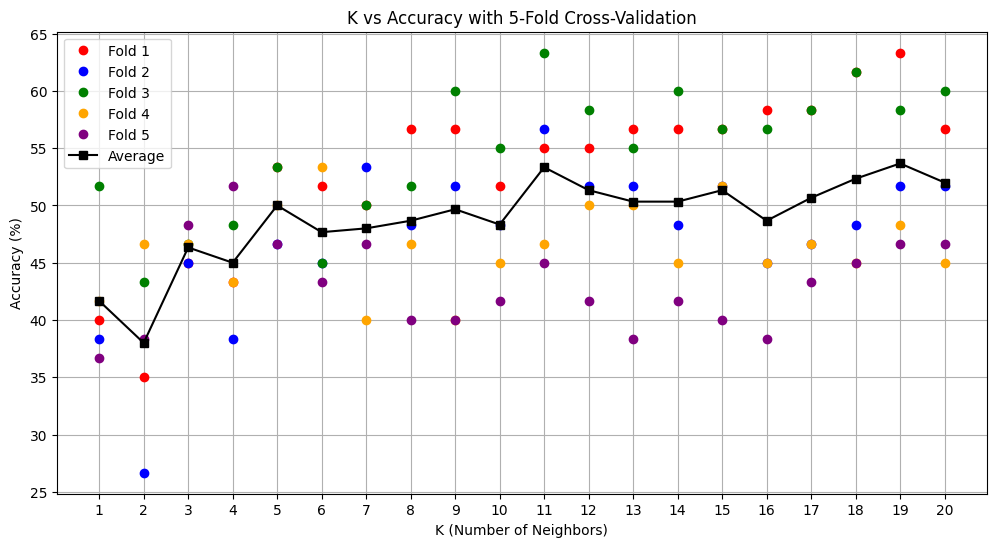

In [12]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(12, 6))

# Plot individual fold points
for i in range(5):
    plt.plot(k_values, [a*100 for a in fold_accuracies[i]],
             linestyle='', marker='o', label=f'Fold {i+1}', color=colors[i])

# Plot average line
plt.plot(k_values, [a*100 for a in average_accuracies],
         linestyle='-', marker='s', color='black', label='Average')

plt.title("K vs Accuracy with 5-Fold Cross-Validation")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.show()